In [ ]:
pip install python_dotenv

In [ ]:
pip install requests

In [ ]:
pip install numpy

In [ ]:
pip install nltk

In [ ]:
pip install pandas

In [ ]:
pip install scikit-learn

In [ ]:
pip install transformers torch

In [ ]:
from dotenv import load_dotenv
import os
import requests
import pandas as pd
from pandas import json_normalize
import json
import numpy as np
import nltk
nltk.download('all')
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
import torch
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [400]:
#Load API key and host
load_dotenv(dotenv_path="api.env")

api_key = os.getenv("API_KEY")
api_host = os.getenv("API_HOST")

In [32]:
#Get continuation_token based on iteration of the for cycle
def get_continuation_token(i:int, data: dict, continuation_data = None) -> str:
    if i >= 1:
        continuation_token = continuation_data["continuation_token"]
    else:
        continuation_token = data["continuation_token"]

    return continuation_token

In [4]:
#Unwrap lists step by step
def flatten_data(data:dict)-> dict:   
    while isinstance(data, list) and len(data) > 0:
        data = data[0]
    
    return data

In [ ]:
#Get user tweets
url = "https://twitter154.p.rapidapi.com/user/tweets"
querystring = {"username":"elonmusk",
               "limit":"40",
               "user_id":"44196397",
               "include_replies":"false",
               "include_pinned":"false"}
headers = {"x-rapidapi-key": api_key,
           "x-rapidapi-host": api_host}

response = requests.get(url, headers=headers, params=querystring)

if response.status_code == 200:  # Check if request was successful
    data = response.json()  # Convert response to Python dictionary+
    with open("tweets.json", "w") as json_file:
        # Write the data to the JSON file
        json.dump(data, json_file, indent=4)  # indent=4 for pretty printing

else:
    print(f"Error: {response.status_code}")

In [ ]:
#Get tweets by twitter ID
num_of_tweets = 2300
tweet_dict_list = []
continuation_token = None

for i in range(num_of_tweets):
        
    continuation_token = get_continuation_token(i, data, continuation_data)
        
    url = "https://twitter-v24.p.rapidapi.com/user/tweets"

    querystring = {"user_id":"44196397","limit":"40"}

    headers = {
        "x-rapidapi-key": api_key,
        "x-rapidapi-host": api_host
    }

    
    if response.status_code == 200:  # Check if request was successful
        continuation_data = response.json()  # Convert response to Python dictionary
        tweet_dict_list.append(continuation_data)
           
        with open("tweets_continue.json", "w") as json_file:
            # Write the data to the JSON file
            json.dump(continuation_data, json_file, indent=4)  # indent=4 for pretty printing
            print("Data has been saved to 'api_response.json'.")
    else:
        print(f"Error: {response.status_code}")


In [ ]:
#Get user details
url = "https://twitter154.p.rapidapi.com/user/details"
querystring = {"username":"elonmusk", "user_id":"44196397"}
headers = {"x-rapidapi-key": api_key,
           "x-rapidapi-host": api_host}

response = requests.get(url, headers = headers, params = querystring)

if response.status_code == 200:  # Check if request was successful
    userData = response.json()  # Convert response to Python dictionary
else:
    print(f"Error: {response.status_code}")

In [ ]:
#Get user continuation tweets with continuation token and merge into a single list

num_of_tweets = 300
tweet_dict_list = []
continuation_token = None

for i in range(num_of_tweets):
        
    continuation_token = get_continuation_token(i, data, continuation_data)
        
    url = "https://twitter154.p.rapidapi.com/user/tweets/continuation"

    querystring = {"username":"elonmusk",
                   "limit":"20",
                   "continuation_token":continuation_token,
                   "user_id":"44196397",
                   "include_replies":"false"}
    headers = {
            "x-rapidapi-key": api_key,
            "x-rapidapi-host": api_host
        }

    response = requests.get(url, headers=headers, params=querystring)

    if response.status_code == 200:  #Check if request was successful
        continuation_data = response.json()  #Convert response to Python dictionary
        tweet_dict_list.append(continuation_data)
           
        with open("tweets_continuation.json", "w") as json_file:
            # Write the data to the JSON file
            json.dump(continuation_data, json_file, indent=4) 
            print("Data has been saved to 'tweets_continuation.json'.")
    else:
        print(f"Error: {response.status_code}")

In [5]:
tweets_df = pd.DataFrame(data)

print(tweets_df.info())
print(tweets_df.head())
print(tweets_df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   results             20 non-null     object
 1   continuation_token  20 non-null     object
dtypes: object(2)
memory usage: 452.0+ bytes
None
                                             results  \
0  {'tweet_id': '1899340251857866790', 'creation_...   
1  {'tweet_id': '1899340160350765477', 'creation_...   
2  {'tweet_id': '1899339287499272238', 'creation_...   
3  {'tweet_id': '1899337145392795803', 'creation_...   
4  {'tweet_id': '1899334891008835806', 'creation_...   

                               continuation_token  
0  DAABCgABGlv34Cp__-gKAAIaW7zte9aQoQgAAwAAAAIAAA  
1  DAABCgABGlv34Cp__-gKAAIaW7zte9aQoQgAAwAAAAIAAA  
2  DAABCgABGlv34Cp__-gKAAIaW7zte9aQoQgAAwAAAAIAAA  
3  DAABCgABGlv34Cp__-gKAAIaW7zte9aQoQgAAwAAAAIAAA  
4  DAABCgABGlv34Cp__-gKAAIaW7zte9aQoQgAAwAAAAIAAA  
results

As we can see from the results of the cell above the dataframe has two columns which points that the json file was highly nested that also is supported by dtypes which shows type objects. If dtype is objects while dhaving distionaries the json is therefore nested. We just need to flatten out the results column.

In [ ]:
#Pretty print
print(json.dumps(data, indent = 4))

In [ ]:
#Create a dataframe
tweets_df = pd.json_normalize(data, record_path = "results")

Just some basic manipulation with df and dict to describe the data I got from API. Basic info, shape and so on.

In [39]:
print(tweets_df.info())
print(tweets_df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Columns: 204 entries, tweet_id to retweet_status.quoted_status.extended_entities
dtypes: bool(8), float64(75), int64(12), object(109)
memory usage: 30.9+ KB
None
tweet_id                                           object
creation_date                                      object
text                                               object
media_url                                          object
video_url                                          object
                                                   ...   
retweet_status.quoted_status.bookmark_count       float64
retweet_status.quoted_status.source               float64
retweet_status.quoted_status.community_note       float64
quoted_status.extended_entities.media              object
retweet_status.quoted_status.extended_entities    float64
Length: 204, dtype: object


In [40]:
#Creating new df with only the text
tweets_text_df = tweets_df["text"]
tweets_text_df

0     RT @DirtyTesLa: 1 year ago today @WifeDirtyTes...
1     RT @EndWokeness: National debt, 1960: $286 bil...
2                                                  Yeah
3     RT @MarioNawfal: ELON: DOGE IS 100% TRANSPAREN...
4     What fixing government computer systems feels ...
5                                                Bravo!
6     RT @MikeBenzCyber: So many ironies here showin...
7                                                  True
8     RT @cybertruck: The only pickup truck with FSD...
9                 Extremely fundamental to your freedom
10    RT @matt_vanswol: I’m angry this morning.\n\nI...
11    RT @Sadie_NC: I think it speaks volumes that y...
12                                                   🔥🔥
13    RT @Scobleizer: Tesla is in a free fall. \n\nI...
14    Much appreciated @SeanHannity!\n https://t.co/...
15    RT @MarioNawfal: 🚨 🇺🇸 CNN ANCHOR LEFT SPEECHLE...
16                                                    🤨
17    RT @RapidResponse47: .@VP: The U.S. unfort

In [41]:
tweets_df["text"][5]

'Bravo!'

In [42]:
tweets_df.shape

(20, 204)

In [43]:
tweets_df.isnull().sum()

tweet_id                                           0
creation_date                                      0
text                                               0
media_url                                         18
video_url                                         19
                                                  ..
retweet_status.quoted_status.bookmark_count       17
retweet_status.quoted_status.source               20
retweet_status.quoted_status.community_note       20
quoted_status.extended_entities.media             18
retweet_status.quoted_status.extended_entities    20
Length: 204, dtype: int64

The same will be done for continuation of tweets of the user

In [45]:
tweets_continuation = pd.json_normalize(tweet_dict_list, record_path="results")
tweets_continuation = pd.DataFrame(tweets_continuation)
tweets_continuation["text"]

0                                                    Yes
1      RT @Starlink: Starlink Mini enables high-speed...
2                                https://t.co/wvHJxQDeCp
3      RT @teslaownersSV: SpaceX is making fully rapi...
4      RT @iam_smx: Elon Musk and his, Son Lil X are ...
                             ...                        
826    A more accurate measure of GDP would exclude g...
827                              https://t.co/3GFeERSg4P
828    RT @WR4NYGov: When my cousin called Elon an "e...
829    RT @MatchasmMatt: Probably nothing... https://...
830                                                 True
Name: text, Length: 831, dtype: object

In [46]:
tweets_continuation.shape

(831, 234)

In [47]:
tweets_continuation["text"]

0                                                    Yes
1      RT @Starlink: Starlink Mini enables high-speed...
2                                https://t.co/wvHJxQDeCp
3      RT @teslaownersSV: SpaceX is making fully rapi...
4      RT @iam_smx: Elon Musk and his, Son Lil X are ...
                             ...                        
826    A more accurate measure of GDP would exclude g...
827                              https://t.co/3GFeERSg4P
828    RT @WR4NYGov: When my cousin called Elon an "e...
829    RT @MatchasmMatt: Probably nothing... https://...
830                                                 True
Name: text, Length: 831, dtype: object

In [48]:
tweets_continuation["text"][22]

'True'

In [49]:
#Creating new df with only the text
tweets_continuation_text = tweets_continuation["text"]
tweets_continuation_text

0                                                    Yes
1      RT @Starlink: Starlink Mini enables high-speed...
2                                https://t.co/wvHJxQDeCp
3      RT @teslaownersSV: SpaceX is making fully rapi...
4      RT @iam_smx: Elon Musk and his, Son Lil X are ...
                             ...                        
826    A more accurate measure of GDP would exclude g...
827                              https://t.co/3GFeERSg4P
828    RT @WR4NYGov: When my cousin called Elon an "e...
829    RT @MatchasmMatt: Probably nothing... https://...
830                                                 True
Name: text, Length: 831, dtype: object

In [51]:
dataframes = [tweets_continuation_text, tweets_text_df]
tweets_text_merged = pd.concat(dataframes)
tweets_text_merged.shape

(851,)

In [52]:
with open('data.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

Now that the tweets are in datagrame and there is enough data we can go ahead with sentiment analysis. First thing first is the data loading which is done and now the next step is data preprocessing for the analysis. Two models will be done acompared which is NLTK and Transformer based such as BERT. 

In [176]:
sentiment_analysis_tweets = tweets_text_merged
sentiment_analysis_tweets.describe()

count     851
unique    757
top       Yes
freq       15
Name: text, dtype: object

In [54]:
isinstance(sentiment_analysis_tweets, pd.DataFrame)

False

In [55]:
print(type(sentiment_analysis_tweets))

<class 'pandas.core.series.Series'>


In [56]:
#change from series to dataframe
sentiment_analysis_tweets_df = sentiment_analysis_tweets.to_frame()
print(type(sentiment_analysis_tweets_df))

<class 'pandas.core.frame.DataFrame'>


In [57]:
sentiment_analysis_tweets_df

,text
0,Yes
1,RT @Starlink: Starlink Mini enables high-speed...
2,https://t.co/wvHJxQDeCp
3,RT @teslaownersSV: SpaceX is making fully rapi...
4,"RT @iam_smx: Elon Musk and his, Son Lil X are ..."
...,...
15,RT @MarioNawfal: 🚨 🇺🇸 CNN ANCHOR LEFT SPEECHLE...
16,🤨
17,RT @RapidResponse47: .@VP: The U.S. unfortunat...
18,RT @GigaBasedDad: Are you paying attention yet...


Preprocessing the text by changing it to lower case then getting rid of any characters on empty spaces also htttp. This will get rid of any noise in the data so that it will not affect modeling.

In [66]:
#Preprocessing the dataframe
def text_preprocessing(df:pd.DataFrame) -> pd.DataFrame:
    #Turn it all to lowercase
    df["text_cleaned"] = df["text"].str.lower()

    #Removing hashtags, URLs and mentions win anononymous function of lambda x and some simple regex expressions
    df["text_cleaned"] = df["text_cleaned"].apply(lambda x: re.sub(r"@\w+|#\w+|http\S+"," ", x))

    #Remove special characters punctuation, numbers and special characters
    df["text_cleaned"] = df["text_cleaned"].apply(lambda x: re.sub(r"[^a-zA-Z\s]", " ", x))

    #Removing 'rt ' from the beginning of the tweet
    df["text_cleaned"] = df["text_cleaned"].apply(lambda x: x[3:] if x.startswith("rt ") else x)

    return df

In [180]:
sentiment_analysis_df = text_preprocessing(sentiment_analysis_tweets_df)

In [182]:
sentiment_analysis_df

,text,text_cleaned
0,Yes,yes
1,RT @Starlink: Starlink Mini enables high-speed...,starlink mini enables high speed internet o...
2,https://t.co/wvHJxQDeCp,
3,RT @teslaownersSV: SpaceX is making fully rapi...,spacex is making fully rapidly reusable roc...
4,"RT @iam_smx: Elon Musk and his, Son Lil X are ...",elon musk and his son lil x are inseparabl...
...,...,...
15,RT @MarioNawfal: 🚨 🇺🇸 CNN ANCHOR LEFT SPEECHLE...,cnn anchor left speechless as majority...
16,🤨,
17,RT @RapidResponse47: .@VP: The U.S. unfortunat...,the u s unfortunately made it way too ...
18,RT @GigaBasedDad: Are you paying attention yet...,are you paying attention yet


According to Smith et al. (2020), sentiment analysis is highly dependent on the preprocessing techniques used to prepare the text. But there is an issue with Tweets from X. With how short they are and how mich or little info can be passed with a text of 280 characters. Based on paper by Saif et al.(2014) found that classical stop word corpuses haas negative impact on classification performance therefore I have decided to use self generated list of stopwords and one with TF-IDF method which has rpoved to work the best in a given paper.

In [178]:
#Removing self generated stop words
def remove_stop_words(df: pd.DataFrame, own_stop_words = None, self_managed=False) -> pd.DataFrame:

    if (self_managed==True):
        word_set = set(own_stop_words["word"])
        stop_words = word_set
    else:
        #stop_words = set(stopwords.words("english"))
        #Self generatzed stop word list
        stop_words = set(["a", "an", "the", "is", "are", "was", "were", "be", "been", "being", 
                        "I", "you", "he", "she", "it", "we", "they", "and", "but", "or", 
                        "so", "to", "of", "in", "on", "for", "with", "at", "by", "as", 
                        "this", "that", "these", "those", "which", "who", "whose", "how", 
                        "when", "why", "too", "also", "just", "really", "quite"])

    # Process each row in the dataframe
    def process_row(text: str) -> str:
        if isinstance(text, str): 
            words = word_tokenize(text)
            
            filtered_words = [w for w in words if w.lower() not in stop_words]
            
            # Return joined words back as a string
            return ' '.join(filtered_words)
        return ""  # Return an empty string if the text is not valid


    df['text_cleaned'] = df['text_cleaned'].apply(process_row)

    return df

In [183]:
sentiment_analysis_df = remove_stop_words(sentiment_analysis_df)
sentiment_analysis_df

,text,text_cleaned
0,Yes,yes
1,RT @Starlink: Starlink Mini enables high-speed...,starlink mini enables high speed internet go
2,https://t.co/wvHJxQDeCp,
3,RT @teslaownersSV: SpaceX is making fully rapi...,spacex making fully rapidly reusable rockets h...
4,"RT @iam_smx: Elon Musk and his, Son Lil X are ...",elon musk his son lil x inseparable hi
...,...,...
15,RT @MarioNawfal: 🚨 🇺🇸 CNN ANCHOR LEFT SPEECHLE...,cnn anchor left speechless majority americans ...
16,🤨,
17,RT @RapidResponse47: .@VP: The U.S. unfortunat...,u s unfortunately made way easy people compete...
18,RT @GigaBasedDad: Are you paying attention yet...,paying attention yet


Here we can see that after preprocessing the text there is 130 rows which are empty and we can get rid of them.

In [184]:
sentiment_analysis_df = sentiment_analysis_df.dropna(subset=["text_cleaned"])
sentiment_analysis_df[sentiment_analysis_df["text_cleaned"] == ""]


,text,text_cleaned
2,https://t.co/wvHJxQDeCp,
5,😎,
6,🎯,
12,https://t.co/5p19OMVNZR,
14,https://t.co/lKsEQWk4Ed,
...,...,...
822,💯,
823,https://t.co/cehFZIXtvI,
827,https://t.co/3GFeERSg4P,
12,🔥🔥,


In [185]:
sentiment_analysis_df = sentiment_analysis_df[sentiment_analysis_df["text_cleaned"].str.strip() != ""]
sentiment_analysis_df

,text,text_cleaned
0,Yes,yes
1,RT @Starlink: Starlink Mini enables high-speed...,starlink mini enables high speed internet go
3,RT @teslaownersSV: SpaceX is making fully rapi...,spacex making fully rapidly reusable rockets h...
4,"RT @iam_smx: Elon Musk and his, Son Lil X are ...",elon musk his son lil x inseparable hi
7,Actual public support for @DOGE is super high!,actual public support super high
...,...,...
14,Much appreciated @SeanHannity!\n https://t.co/...,much appreciated
15,RT @MarioNawfal: 🚨 🇺🇸 CNN ANCHOR LEFT SPEECHLE...,cnn anchor left speechless majority americans ...
17,RT @RapidResponse47: .@VP: The U.S. unfortunat...,u s unfortunately made way easy people compete...
18,RT @GigaBasedDad: Are you paying attention yet...,paying attention yet


TF-IDF also known as Term Frequency-Inverse Document Frequency is a measure in statistitcs that is used in natural language programming to show/evaluate importance of a word in the document relative to a collection of documents. 

TF - Measures how often a word appears in a document. If a word appears frequently in a document, it is likely relevant to the document’s content

IDF - Reduces the weight of common words across multiple documents while increasing the weight of rare words. If a term appears in fewer documents, it is more likely to be meaningful and specific.

In [ ]:
#Changing dataframe to a list
text = sentiment_analysis_df["text"].tolist()

In [187]:
#Creating the TF-IDF vectorizer to get sop_words 
def create_stop_words_tfid(text:list)-> pd.DataFrame:
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(text)
    tfidf_df = pd.DataFrame(tfidf_vectorizer_vectors.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
    
    #Calculating the average score for each word(axis=0->per word )
    tfidf_scores = tfidf_df.mean(axis=0).reset_index()
    tfidf_scores.columns = ['word', 'tfidf_score']

    #Sort by TF-IDF score
    tfidf_scores = tfidf_scores.sort_values(by="tfidf_score", ascending=False)

    return tfidf_scores

In [188]:
stop_words_tfidf = create_stop_words_tfid(text)
print(stop_words_tfidf.head(10))

       word  tfidf_score
2563    the     0.047858
2214     rt     0.040086
2612     to     0.037016
1268  https     0.032376
527      co     0.031339
1375     is     0.029565
1803     of     0.028686
2923    yes     0.026158
1318     in     0.023849
212     and     0.023795


In [ ]:
#Show the whole df with stop wrods
with pd.option_context("display.max_rows", None,):   
    print(stop_words_tfidf)

In [190]:
#Removing rows based on condition for TF-IDF score
score = 0.01
stop_words_defined = stop_words_tfidf[stop_words_tfidf["tfidf_score"] >= score]
stop_words_defined

,word,tfidf_score
2563,the,0.047858
2214,rt,0.040086
2612,to,0.037016
1268,https,0.032376
527,co,0.031339
1375,is,0.029565
1803,of,0.028686
2923,yes,0.026158
1318,in,0.023849
212,and,0.023795


In [192]:
#Creating a new dataframe with own stop words romoved
sentiment_analysis_df_copy = sentiment_analysis_df.copy()
sentiment_analysis_2_df = remove_stop_words(sentiment_analysis_df_copy, stop_words_defined, self_managed=True, )
sentiment_analysis_2_df = sentiment_analysis_2_df[sentiment_analysis_2_df["text_cleaned"].str.strip() != ""].copy()
sentiment_analysis_2_df

,text,text_cleaned
1,RT @Starlink: Starlink Mini enables high-speed...,starlink mini enables high speed internet go
3,RT @teslaownersSV: SpaceX is making fully rapi...,spacex making fully rapidly reusable rockets h...
4,"RT @iam_smx: Elon Musk and his, Son Lil X are ...",his son lil x inseparable hi
7,Actual public support for @DOGE is super high!,actual public support super high
8,"RT @cb_doge: 🚨 KUDLOW: ""Everyone is trying to ...",kudlow everyone trying drive wedge between i d...
...,...,...
14,Much appreciated @SeanHannity!\n https://t.co/...,much appreciated
15,RT @MarioNawfal: 🚨 🇺🇸 CNN ANCHOR LEFT SPEECHLE...,cnn anchor left speechless majority americans ...
17,RT @RapidResponse47: .@VP: The U.S. unfortunat...,u s unfortunately made way easy compete agains...
18,RT @GigaBasedDad: Are you paying attention yet...,paying attention yet


The last process is lemmetization. It stems from the word lemmatize, which means reducing the different forms of a word to one single form. Lemmatization has a pre-defined dictionary that stores the context of words and checks the word in the dictionary while shrinking the word.

In [241]:
def lemmatize(df: pd.DataFrame) -> pd.DataFrame:
    lemmatizer = WordNetLemmatizer()

    def lemmatize_each_row(text: str) -> str:
        words = text.split()
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

        return " ".join(lemmatized_words)

    df["text_cleaned"] = df["text_cleaned"].apply(lemmatize_each_row)
    
    return df

In [243]:
sentiment_analysis_2_df = lemmatize(sentiment_analysis_2_df)
sentiment_analysis_df = lemmatize(sentiment_analysis_df)

Now moving onto the models itself. Using both of these datasets to determine which model is better given the circumstances, data and preprocessing.

The Vader sentiment analysis scores the text/tweet with three scores positve, negative, neutral. For each of these it returns a value. Then later with condition we will add sentiment label based on the score.

In [ ]:
#Creating the VADER sentiment anylzer (part of NLTK library)
analyzer = SentimentIntensityAnalyzer()

#Getting the sentiment values for each tweet
sentiment_analysis_2_df["vader_sentiment"] = sentiment_analysis_2_df["text_cleaned"].apply(lambda x: analyzer.polarity_scores(x)["compound"])
sentiment_analysis_df["vader_sentiment"] = sentiment_analysis_df["text_cleaned"].apply(lambda x: analyzer.polarity_scores(x)["compound"])

#Adding label of "POS, NEG or NEU" for polarity scores


,text,text_cleaned,vader_sentiment
1,RT @Starlink: Starlink Mini enables high-speed...,starlink mini enables high speed internet go,0.0000
3,RT @teslaownersSV: SpaceX is making fully rapi...,spacex making fully rapidly reusable rocket ho...,0.0000
4,"RT @iam_smx: Elon Musk and his, Son Lil X are ...",his son lil x inseparable hi,0.0000
7,Actual public support for @DOGE is super high!,actual public support super high,0.7650
8,"RT @cb_doge: 🚨 KUDLOW: ""Everyone is trying to ...",kudlow everyone trying drive wedge between i d...,0.4939
...,...,...,...
14,Much appreciated @SeanHannity!\n https://t.co/...,much appreciated,0.5106
15,RT @MarioNawfal: 🚨 🇺🇸 CNN ANCHOR LEFT SPEECHLE...,cnn anchor left speechless majority american b...,-0.4215
17,RT @RapidResponse47: .@VP: The U.S. unfortunat...,u s unfortunately made way easy compete agains...,0.6369
18,RT @GigaBasedDad: Are you paying attention yet...,paying attention yet,0.0000


In [251]:
def label_sentiment(score:int)-> str:
    if score >= 0.05:
        return 'POS'
    elif score <= -0.05:
        return 'NEG'
    else:
        return 'NEU'

sentiment_analysis_2_df["vader_label"] = sentiment_analysis_2_df["vader_sentiment"].apply(label_sentiment)
sentiment_analysis_df["vader_label"] = sentiment_analysis_df["vader_sentiment"].apply(label_sentiment)

sentiment_analysis_2_df

,text,text_cleaned,vader_sentiment,vader_label
1,RT @Starlink: Starlink Mini enables high-speed...,starlink mini enables high speed internet go,0.0000,NEU
3,RT @teslaownersSV: SpaceX is making fully rapi...,spacex making fully rapidly reusable rocket ho...,0.0000,NEU
4,"RT @iam_smx: Elon Musk and his, Son Lil X are ...",his son lil x inseparable hi,0.0000,NEU
7,Actual public support for @DOGE is super high!,actual public support super high,0.7650,POS
8,"RT @cb_doge: 🚨 KUDLOW: ""Everyone is trying to ...",kudlow everyone trying drive wedge between i d...,0.4939,POS
...,...,...,...,...
14,Much appreciated @SeanHannity!\n https://t.co/...,much appreciated,0.5106,POS
15,RT @MarioNawfal: 🚨 🇺🇸 CNN ANCHOR LEFT SPEECHLE...,cnn anchor left speechless majority american b...,-0.4215,NEG
17,RT @RapidResponse47: .@VP: The U.S. unfortunat...,u s unfortunately made way easy compete agains...,0.6369,POS
18,RT @GigaBasedDad: Are you paying attention yet...,paying attention yet,0.0000,NEU


Since for these data there are no ground truth labels for evalution matrix. There are only typical statiscal evaluations we can do on these model to see how have they behaved. What I will present with commentary is compare distribution of sentiment scores, compare mean and standard deviation of sentiment scores, statistical test - T-test paired. With these we can get clear idea how these two models behave.

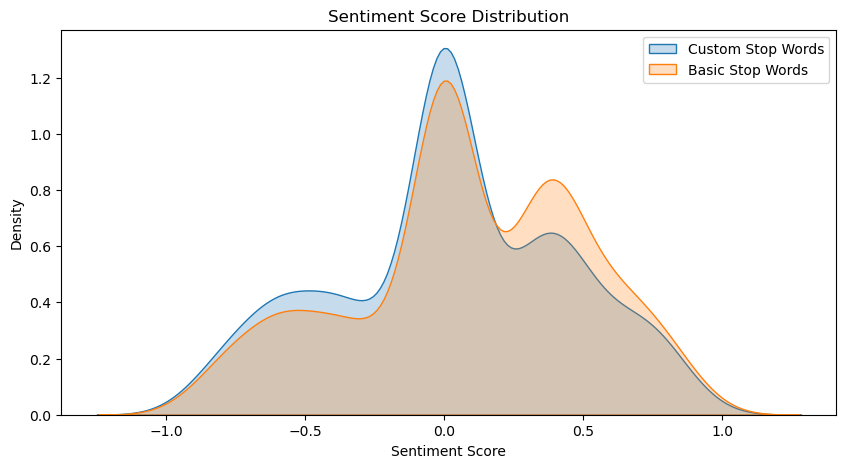

In [255]:
#Comparing distribution of sentiment scores
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.kdeplot(sentiment_analysis_2_df['vader_sentiment'], label='Custom Stop Words', fill=True)
sns.kdeplot(sentiment_analysis_df['vader_sentiment'], label='Basic Stop Words', fill=True)
plt.legend()
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.show()

As we can see in the graph above both custom and basic stop words data show a peak around 0. Meaning that most of the tweets are labeled as neutral, but data with a custom stop word list (from TF-IDF) has a higher peak. This could be interpreted as the basic stop words list removing words that could influence the sensitivity analysis so that it would label it as neutral. The same for the left side of the graph. On the other hand, both models show a slight bias towards the positivity label as there is a slight peak but bigger for the basic stop word list. This shows that the opposite is happening here where the custom stop word list is removing stop words that could influence labeling tweet as positive.

In [ ]:
#Compare mean and standard deviation of sentiment scores
print("Mean sentiment score for custom stop word list is:", sentiment_analysis_2_df['vader_sentiment'].mean())
print("Standard deviation for custom stop word list is:", sentiment_analysis_2_df['vader_sentiment'].std())

print("Mean sentiment score for basic stop word list is:", sentiment_analysis_df['vader_sentiment'].mean())
print("Standard deviation for basic stop word list is:", sentiment_analysis_df['vader_sentiment'].std())

Mean sentiment score for custom stop word list is: 0.027297568389057753
Standard deviation for custom stop word list is: 0.42037737977301454
Mean sentiment score for basic stop word list is: 0.08368085991678224
Standard deviation for basic stop word list is: 0.42259936644774665


With these scores and graph, we can say that the custom stop word model is indeed more neutral as the score 0.27 is closer to 0 and the basic stop word list is 0.084 closer to 1 showing the bias towards right so positive sentiment. So the basic leans more toward positive sentiment and the basic leans toward neutral.
Also with standard deviation identical when rounded to 2 decimal places being 0.42. This shows that the spread of labels/sentiment is the same for 2 models. Neither model introduces a significant change to the results.

In [264]:
#T-test paired
import scipy.stats as stats 
t_test, p_value=stats.ttest_ind(sentiment_analysis_df["vader_sentiment"],sentiment_analysis_2_df["vader_sentiment"], equal_var=False)
print("The result of paired t-test is:",t_test)
print("The p-value is:",p_value)


The result of paired t-test is: 2.4814987907141597
The p-value is: 0.013202581643022519


For the statistical paired t-test (Welch´s test) we work with two hypotheses.
H0: μ_basic = μ_custom
H1: μ_basic​ != μ_custom
This means that the null hypothesis H0 is rejected and the results of sentiments are statistically different because p_value 0.013 is lower than 0.05 which is alfa or b so-called significance level. This also is supported by the difference means each model has resp. 0.084 and 0.027.

The results are clear. There is a significant difference between these two models and their scores. Each stop word set influences the score in a way thus it is one of the crucial parts in this analysis. But if I had to choose I would prefer the custom stop word list based on the TF-IDF method which is also supported in the journal article Saif et al.(2014) On Stopwords, Filtering and Data Sparsity for Sentiment Analysis of Twitter
Hassan Saif, Miriam Fernandez, Yulan He, Harith Alani.

Now for the second model the BERT model which is machine learning model and should provide more insight than rule based model such as VADER. This class provides functionality to tokenize text data using a pre-trained BERT tokenizer bert-base-uncased.

In [ ]:
#Creating BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_text(df: pd.DataFrame)->pd.DataFrame:
    tokenized_text = df["text_cleaned"].apply(lambda x: tokenizer(x, padding=True, truncation=True, max_length=128, return_tensors="pt"))

    #Extract each row so that it is not list of lists
    df[""] = tokenized_text.apply(lambda x: x[""].squeeze().tolist())
    df["attention_mask"] = tokenized_text.apply(lambda x: x["attention_mask"].squeeze().tolist())
    df["token_type_ids"] = tokenized_text.apply(lambda x: x["token_type_ids"].squeeze().tolist() if "token_type_ids" in x else [])

    return df


In [ ]:
tweet = "I absolutely love this new phone! #excited"
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# Tokenize the tweet
encoded_input = tokenizer(tweet, return_tensors='pt', padding=True, truncation=True, max_length=128)


# View the tokenized output
print(encoded_input)

{'input_ids': tensor([[ 101, 1045, 7078, 2293, 2023, 2047, 3042,  999, 1001, 7568,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [292]:
tokenized_sentiment_analysis = tokenize_text(sentiment_analysis_df)
tokenized_sentiment_analysis_2 = tokenize_text(sentiment_analysis_2_df)

In [293]:
print(tokenized_sentiment_analysis.head())

                                                text  \
0                                                Yes   
1  RT @Starlink: Starlink Mini enables high-speed...   
3  RT @teslaownersSV: SpaceX is making fully rapi...   
4  RT @iam_smx: Elon Musk and his, Son Lil X are ...   
7     Actual public support for @DOGE is super high!   

                                        text_cleaned  vader_sentiment  \
0                                                yes           0.4019   
1       starlink mini enables high speed internet go           0.0000   
3  spacex making fully rapidly reusable rocket ho...           0.0000   
4             elon musk his son lil x inseparable hi           0.0000   
7                   actual public support super high           0.7650   

  vader_label                                          input_ids  \
0         POS                                   [101, 2748, 102]   
1         NEU  [101, 2732, 13767, 7163, 12939, 2152, 3177, 42...   
3         NEU  [101,

Each dictionary contains tokenized information for one tweet, including:

input_ids - The list of token IDs corresponding to the tweet
attention_mask - The mask indicates which tokens are actual words (1) and which are padding (0) padding is used so that each sequence that is processed has the same size.
Also the .squeeze() method removes any dimensions of size 1 from the PyTorch tensor.

In [295]:
tokenized_sentiment_analysis

,text,text_cleaned,vader_sentiment,vader_label,input_ids,attention_mask,token_type_ids
0,Yes,yes,0.4019,POS,"[101, 2748, 102]","[1, 1, 1]","[0, 0, 0]"
1,RT @Starlink: Starlink Mini enables high-speed...,starlink mini enables high speed internet go,0.0000,NEU,"[101, 2732, 13767, 7163, 12939, 2152, 3177, 42...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,RT @teslaownersSV: SpaceX is making fully rapi...,spacex making fully rapidly reusable rocket ho...,0.0000,NEU,"[101, 2686, 2595, 2437, 3929, 5901, 2128, 1038...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,"RT @iam_smx: Elon Musk and his, Son Lil X are ...",elon musk his son lil x inseparable hi,0.0000,NEU,"[101, 3449, 2239, 14163, 6711, 2010, 2365, 134...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
7,Actual public support for @DOGE is super high!,actual public support super high,0.7650,POS,"[101, 5025, 2270, 2490, 3565, 2152, 102]","[1, 1, 1, 1, 1, 1, 1]","[0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...
14,Much appreciated @SeanHannity!\n https://t.co/...,much appreciated,0.5106,POS,"[101, 2172, 12315, 102]","[1, 1, 1, 1]","[0, 0, 0, 0]"
15,RT @MarioNawfal: 🚨 🇺🇸 CNN ANCHOR LEFT SPEECHLE...,cnn anchor left speechless majority american b...,-0.4215,NEG,"[101, 13229, 8133, 2187, 25146, 3484, 2137, 20...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
17,RT @RapidResponse47: .@VP: The U.S. unfortunat...,u s unfortunately made way easy people compete...,0.6369,POS,"[101, 1057, 1055, 6854, 2081, 2126, 3733, 2111...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
18,RT @GigaBasedDad: Are you paying attention yet...,paying attention yet,0.0000,NEU,"[101, 7079, 3086, 2664, 102]","[1, 1, 1, 1, 1]","[0, 0, 0, 0, 0]"


In [ ]:
print(tokenized_sentiment_analysis.iloc[0])


text                            Yes
text_cleaned                    yes
vader_sentiment              0.4019
vader_label                     POS
input_ids          [101, 2748, 102]
attention_mask            [1, 1, 1]
token_type_ids            [0, 0, 0]
Name: 0, dtype: object


In [319]:
#Extracting the tokenized information
sentiment_analysis_df["input_ids"] = tokenized_sentiment_analysis.apply(lambda row: row["input_ids"] if isinstance(row["input_ids"], list) else [], axis=1)
sentiment_analysis_df["attention_mask"] = tokenized_sentiment_analysis.apply(lambda row: row["attention_mask"] if isinstance(row["attention_mask"], list) else [], axis=1)
sentiment_analysis_df["token_type_ids"] = tokenized_sentiment_analysis.apply(lambda row: row["token_type_ids"] if "token_type_ids" in row else [], axis=1)

sentiment_analysis_2_df["input_ids"] = tokenized_sentiment_analysis_2.apply(lambda row: row["input_ids"] if isinstance(row["input_ids"], list) else [], axis=1)
sentiment_analysis_2_df["attention_mask"] = tokenized_sentiment_analysis_2.apply(lambda row: row["attention_mask"] if isinstance(row["attention_mask"], list) else [], axis=1)
sentiment_analysis_2_df["token_type_ids"] = tokenized_sentiment_analysis_2.apply(lambda row: row["token_type_ids"] if "token_type_ids" in row else [], axis=1)

In [ ]:
#Splitting the data fro training a testing
X_train, X_test, y_train, y_test = train_test_split(sentiment_analysis_df[])

In [ ]:
#Creating BERT model
model = BertModel.from_pretrained("bert-base-uncased")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

This function extracts the embeddings from a pre-trained BERT model for a given tokenized input. Since the model is pre-trained there is no need to worry about the model learning anything new from the first dataframe which is put through it. Extracting the embeddings of the [CLS] token, which is a special token added at the beginning of each input sequence in BERT for classification or other tasks and the [SEP] token marks the end of the input sequence.

In [ ]:
#Extracting embeddings
def get_embeddings(tokens):
    with torch.no_grad():
        outputs = model(input_ids=torch.tensor([tokens["input_ids"]]),
                        attention_mask=torch.tensor([tokens["attention_mask"]]),
                        token_type_ids=torch.tensor([tokens["token_type_ids"]]) if "token_type_ids" in tokens else None)
        return outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    
#Apply embeddings to each row (axis = 1)
sentiment_analysis_df["embeddings"] = sentiment_analysis_df.apply(lambda row: get_embeddings({
    "input_ids": row["input_ids"],
    "attention_mask": row["attention_mask"],
    "token_type_ids": row["token_type_ids"]
}), axis=1)

In [ ]:
sentiment_analysis_2_df["embeddings"] = sentiment_analysis_2_df.apply(lambda row: get_embeddings({
    "input_ids": row["input_ids"],
    "attention_mask": row["attention_mask"],
    "token_type_ids": row["token_type_ids"]
}), axis=1)

In [326]:
print(sentiment_analysis_df[["text", "embeddings"]])

                                                 text  \
0                                                 Yes   
1   RT @Starlink: Starlink Mini enables high-speed...   
3   RT @teslaownersSV: SpaceX is making fully rapi...   
4   RT @iam_smx: Elon Musk and his, Son Lil X are ...   
7      Actual public support for @DOGE is super high!   
..                                                ...   
14  Much appreciated @SeanHannity!\n https://t.co/...   
15  RT @MarioNawfal: 🚨 🇺🇸 CNN ANCHOR LEFT SPEECHLE...   
17  RT @RapidResponse47: .@VP: The U.S. unfortunat...   
18  RT @GigaBasedDad: Are you paying attention yet...   
19  RT @WallStreetApes: Elon Musk explains the NGO...   

                                           embeddings  
0   [-0.30237678, 0.2931397, -0.055863995, -0.0921...  
1   [-0.3588954, -0.23392645, 0.056638043, 0.07893...  
3   [-0.5385479, -0.03152224, 0.13896738, -0.01198...  
4   [-0.41037434, 0.12710425, -0.12426515, 0.32823...  
7   [-0.13843504, 0.022904225, 0.02

Now the K mean clustering method will be used to cluster similiar tweets under one categeory based on how close they are together in space. Base on number of k(centroids) will it calculate to which cluster it belongs.

In [409]:
#Clusterins with K-Means
embeddings_1 = np.array(sentiment_analysis_df["embeddings"].tolist())
embeddings_2 = np.array(sentiment_analysis_2_df["embeddings"].tolist())

number_of_clusters = 3
K_means = KMeans(n_clusters=number_of_clusters, random_state=25)

K_means.fit(embeddings_1)

c:\Users\tomas\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


KMeans(n_clusters=3, random_state=25)

In [381]:
sentiment_analysis_df["cluster"] = K_means.labels_

In [382]:
K_means.fit(embeddings_2)

c:\Users\tomas\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


KMeans(n_clusters=3, random_state=25)

In [383]:
sentiment_analysis_2_df["cluster"] = K_means.labels_

In [384]:
print(sentiment_analysis_df[["text_cleaned", "cluster"]].head())

                                        text_cleaned  cluster
0                                                yes        1
1       starlink mini enables high speed internet go        0
3  spacex making fully rapidly reusable rocket ho...        0
4             elon musk his son lil x inseparable hi        0
7                   actual public support super high        0


Now that we got embeddings calculated from input_ids, attention_mask, token_type_ids and have done clustering using K means we can visualize the results with 3 cluster which coudl be postive, negative and neutral.
But first thing first is that the reduction of dimensions is needed because "bert-base-uncased" uses default size vector of 768 dimensionand we cannot visualize that. Therefore the PCA (Principal Component Analysis) is used because it reduces dimensionality while leaving as much information as possible.

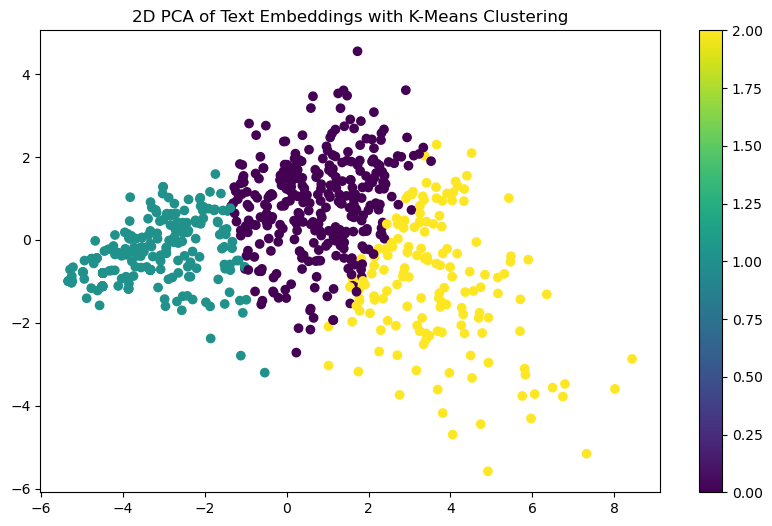

In [385]:
#Use PCA to reduce the embeddings to 2D for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_1)

sentiment_analysis_df["pca_1"] = reduced_embeddings[:, 0]
sentiment_analysis_df["pca_2"] = reduced_embeddings[:, 1]

#USing scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x = sentiment_analysis_df["pca_1"], y = sentiment_analysis_df["pca_2"], c=sentiment_analysis_df["cluster"], cmap="viridis")
plt.colorbar()
plt.title("2D PCA of Text Embeddings with K-Means Clustering")
plt.show()

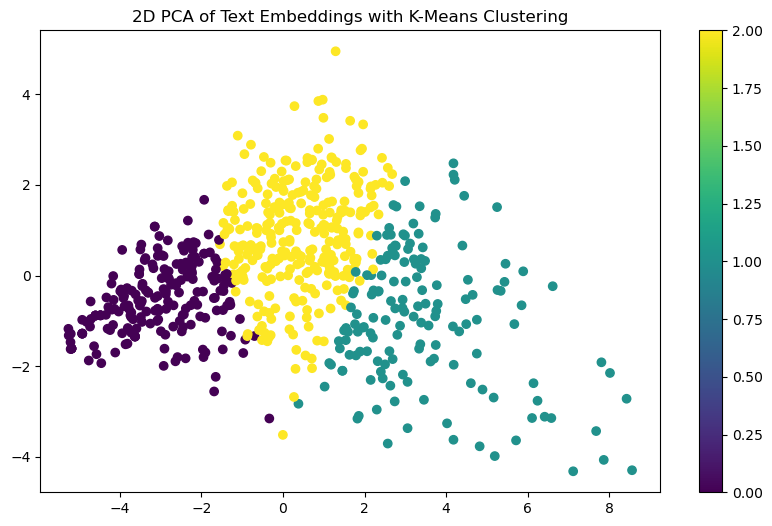

In [390]:
#Use PCA to reduce the embeddings to 2D for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_2)

sentiment_analysis_2_df["pca_1"] = reduced_embeddings[:, 0]
sentiment_analysis_2_df["pca_2"] = reduced_embeddings[:, 1]

#USing scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x = sentiment_analysis_2_df["pca_1"], y = sentiment_analysis_2_df["pca_2"], c=sentiment_analysis_2_df["cluster"], cmap="viridis")
plt.colorbar()
plt.title("2D PCA of Text Embeddings with K-Means Clustering")
plt.show()

In [393]:
print(tokenized_sentiment_analysis[["cluster", "embeddings"]].head())
print(tokenized_sentiment_analysis_2[["cluster", "embeddings"]].head())

   cluster                                         embeddings
0        1  [-0.30237678, 0.2931397, -0.055863995, -0.0921...
1        0  [-0.3588954, -0.23392645, 0.056638043, 0.07893...
3        0  [-0.5385479, -0.03152224, 0.13896738, -0.01198...
4        0  [-0.41037434, 0.12710425, -0.12426515, 0.32823...
7        0  [-0.13843504, 0.022904225, 0.020527555, 0.3367...
   cluster                                         embeddings
1        2  [-0.3588954, -0.23392645, 0.056638043, 0.07893...
3        2  [-0.5385479, -0.03152224, 0.13896738, -0.01198...
4        2  [-0.5525136, 0.058236405, -0.025181722, 0.1508...
7        2  [-0.13843504, 0.022904225, 0.020527555, 0.3367...
8        0  [0.10943077, 0.13378796, 0.16734082, -0.145439...


Using the scatterplot and head() function we can see that there has been a difference in clustering. The only difference between these two models is the usage of stop words basic and custom set. Based on article Moradi et. al.(2021) "The evaluations on various NLP tasks imply that these models are sensitive to different
character-level and word-level perturbations to the input, and the models’ performance can decrease
when the input contains slight noise." Which show that even on large scale or big data the BERT model is not very robust and can be affected with minor changes to the text. Which would explain the different results with basic and custom stop words sets. This could possibly be aliviated with pre-training the model on the data which we are going to be testing it on instead usin pre-trained model. Also with larger dataset. 

So to summarize the results for rule based model VADER we got similiar results. The difference in sets for stop words did not affect it as much as BERT but we still could find that those two datasets were statistically different. This difference only rose in power when used with BERT a deep learning model. Where the changes in preprocessing produced completely different results and even different classification according to K-Means.
Further fine-tuning and larger dataset could offset this problem. Also with using specific set for stop words removal for socail media could aid in getting robust results. 

In [394]:
#Saving the results to a JSON file
sentiment_analysis_df.to_json('sentiment_analysis_df.json', orient='records', lines=True)
sentiment_analysis_2_df.to_json('sentiment_analysis_2_df.json', orient='records', lines=True)